# Analysis of CRDC referral and arrest data 


This notebook contains analysis of data from the US Department of Education Civil Rights Data Collection related to arrests and law enforcement referrals of elementary school children in the US.

## Definitions

All definitions here are from the [Master List of Definitions for the 2015-2016 CRDC](https://ocrdata.ed.gov/assets/downloads/CRDC-Definitions-2015-16.pdf).

### Referral to law enforcement

> "...an action by which a student is reported to any law enforcement agency or official, including a school police unit, for an incident that occurs on school grounds, during schoolrelated events, or while taking school transportation, regardless of whether official action is taken. Citations, tickets, court referrals, and school-related arrests are considered referrals to law enforcement."

### School-Related Arrest

> "...an arrest of a student for any activity conducted on school grounds, during offcampus school activities (including while taking school transportation), or due to a referral by any school official. All school-related arrests are considered referrals to law enforcement."

### Children with Disabilities (IDEA)
> "...children with intellectual disabilities; hearing impairment, including deafness; speech or language impairment; visual impairment, including blindness; serious emotional disturbance; orthopedic impairment; autism; traumatic brain injury; developmental delay; other health impairment; specific learning disability; deaf-blindness; or multiple disabilities and who, by reason thereof, receive special education and related services under the Individuals with Disabilities Education Act according to an Individualized Education Program, Individual Family Service Plan, or service plan."

### Students With Disabilities (Section 504 Only)
> "...students with a disability, who receive related aids and services solely under Section 504 of the Rehabilitation Act of 1973, as amended, and not under the Individuals with Disabilities Education Act (IDEA). The "Section 504 Only" column in the survey items always refers to students with disabilities who receive related aids and services under Section 504 of the Rehabilitation Act of 1973, as amended, and not under IDEA."

In [14]:
import re
import geopandas as gpd
import numpy as np
import pandas as pd


In [15]:
read_df = (
    lambda filename: pd.read_csv(filename, low_memory=False, encoding="latin")
    .rename(columns=lambda col: col.lower())
    .replace(
        {
            -3: np.NaN,
            -5: np.NaN,
            -6: np.NaN,
            -8: np.NaN,
            -9: np.NaN,
            -11: np.NaN,
        }
    )
)

enr = read_df("input/1718-crdc-sch-enrollment.csv")
arr = read_df("input/1718-crdc-sch-referrals-arrests.csv")
cha = read_df("input/1718-crdc-sch-characteristics.csv")


## Overall rates

This analysis is limited to the following criteria:
1. students grades 5 or younger
2. non-juvenile justice facilities
3. non-alternative schools

It will provide referral and arrest rates per 10,000 children

In [16]:
# papermill parameters
MAX_GRADE = 5


In [18]:
# constants
JOIN_ARGS = {"how": "left"}
INDEX_COLS = [
    "combokey",
    "sch_name",
    "lea_name",
    "lea_state_name",
    "jj",
]
MULT = 10_000
RACE_VALUES = {
    "am": "American Indian/Alaska Native",
    "as": "Asian",
    "bl": "Black",
    "wh": "White",
    "hi": "Hispanic",
    "hp": "Native Hawaiian/Pacific Islander",
    "tr": "Two or More Races",
}


In [19]:
sum_sch = lambda df, kwd, colname: (
    df.set_index(INDEX_COLS)[[c for c in df if "tot_" in c and kwd in c]]
    .sum(axis=1)
    .to_frame(colname)
)


def get_max_grade(row):
    true_cols = [
        (k, v) for k, v in row.iteritems() if k.startswith("sch_grade_g") and v == "Yes"
    ]
    if len(true_cols) == 0:
        return np.NaN
    return int(re.search(r"(?<=sch_grade_g)\d{1,2}$", true_cols[-1][0]).group())


cha = cha.set_index(INDEX_COLS).assign(
    max_grade=lambda df: df.apply(get_max_grade, axis=1)
)[["sch_status_alt", "max_grade"]]


assign_rates = lambda df: (
    df.assign(arrest_rate=lambda df: df.arrests / df.enrollment * MULT).assign(
        referral_rate=lambda df: df.referrals / df.enrollment * MULT
    )
)

tot_df_query = lambda max_grade: f"max_grade <= @MAX_GRADE & index.get_level_values('jj') == 'No' & sch_status_alt == 'No'"

tot_df = (
    sum_sch(enr, "enr", "enrollment")
    .join(cha, **JOIN_ARGS)
    .join(sum_sch(arr, "arr", "arrests"), **JOIN_ARGS)
    .join(sum_sch(arr, "ref", "referrals"), **JOIN_ARGS)
    .query(
        "max_grade <= @MAX_GRADE & index.get_level_values('jj') == 'No' & sch_status_alt == 'No'"
    )
    .pipe(assign_rates)
)

tot_df.to_csv(f"output/school totals, grade {MAX_GRADE} and below.csv")


/tmp/ipykernel_2907/4159563421.py:10: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  (k, v) for k, v in row.iteritems() if k.startswith("sch_grade_g") and v == "Yes"


### National

Nationwide, there are about 5 referrals and 1 arrest for every 10,000 children enrolled in elementary schools.

In [20]:
national_rates = (
    tot_df[["enrollment", "referrals", "arrests"]]
    .sum()
    .to_frame("United States")
    .transpose()
    .pipe(assign_rates)
    .iloc[0]
)

national_rates.to_frame("United States").round(2)


,United States
enrollment,47888687.00
referrals,84365.00
arrests,16638.00
arrest_rate,3.47
referral_rate,17.62


### By state

The rates of referrals and arrests aren't consistent across states. Some states have rates many times the national average.

In [21]:
state_rates = (
    tot_df.reset_index()
    .groupby("lea_state_name")[["enrollment", "arrests", "referrals"]]
    .sum()
    .pipe(assign_rates)
    .sort_values(["referral_rate", "arrest_rate"], ascending=False)
)

state_rates


,enrollment,arrests,referrals,arrest_rate,referral_rate
lea_state_name,,,,,
VIRGINIA,1228114.0,897.0,8188.0,7.303882,66.671335
PENNSYLVANIA,1380810.0,1054.0,7106.0,7.633201,51.462547
NEW HAMPSHIRE,158284.0,93.0,587.0,5.875515,37.085239
FLORIDA,2749252.0,646.0,9041.0,2.349730,32.885308
SOUTH DAKOTA,127360.0,108.0,417.0,8.479899,32.741834
MISSOURI,789198.0,813.0,2491.0,10.301597,31.563689
WISCONSIN,758221.0,251.0,2195.0,3.310380,28.949343
DELAWARE,123153.0,66.0,337.0,5.359187,27.364335
MONTANA,126499.0,65.0,343.0,5.138381,27.114839


### Individual schools

I'm using some additional criteria to identify problematic schools:
1. At least 100 students enrolled
2. Referral rate at least 5 times the national average
3. Arrest rate at least double the national average

This leaves us with a list of between 100 and 200 schools to focus on

In [22]:
REFERRAL_RATE_THRESHOLD = national_rates.referral_rate * 3
ARREST_RATE_THRESHOLD = national_rates.arrest_rate * 2

problem_schools = (
    tot_df.pipe(assign_rates)
    .query(
        "enrollment >= 100 "
        "& referral_rate >= @REFERRAL_RATE_THRESHOLD"
        "& arrest_rate >= @ARREST_RATE_THRESHOLD"
    )
    .sort_values("referral_rate", ascending=False)
    # geocode schools using NCES school locations file
    # https://nces.ed.gov/programs/edge/geographic/schoollocations
    .pipe(
        lambda df: gpd.read_file("input/EDGE_GEOCODE_PUBLICSCH_1718")
        .to_crs("EPSG:4326")
        .merge(
            df.reset_index(), how="right", left_on=["NCESSCH"], right_on=["combokey"]
        )
    )
    # join nielsen DMAs so I know which to send to which local station
    .pipe(
        lambda df: gpd.sjoin(
            gpd.read_file("input/nielsen-dmas.geojson")[
                ["nielsen_dma", "geometry"]
            ].drop_duplicates(),
            df,
            how="right",
            predicate="contains",
        )
    )[
        INDEX_COLS[:-1]
        + [
            "nielsen_dma",
            "max_grade",
            "arrests",
            "referrals",
            "arrest_rate",
            "referral_rate",
        ]
    ]
)

problem_schools


,combokey,sch_name,lea_name,lea_state_name,nielsen_dma,max_grade,arrests,referrals,arrest_rate,referral_rate
0,530645002813,Ptarmigan Ridge Elementary School,Orting School District,WASHINGTON,Seattle-Tacoma,5.0,484.0,483.0,4923.702950,4913.530010
1,530645002066,Orting Middle School,Orting School District,WASHINGTON,Seattle-Tacoma,8.0,212.0,213.0,3011.363636,3025.568182
2,481662012337,DAILEY MIDDLE,DEL VALLE ISD,TEXAS,"Austin, TX",8.0,351.0,350.0,2562.043796,2554.744526
3,481662009527,JOHN P OJEDA MIDDLE,DEL VALLE ISD,TEXAS,"Austin, TX",8.0,447.0,446.0,2475.083056,2469.545958
4,481662001425,DEL VALLE MIDDLE,DEL VALLE ISD,TEXAS,"Austin, TX",8.0,381.0,381.0,2066.160521,2066.160521
...,...,...,...,...,...,...,...,...,...,...
1544,510324000381,Barack Obama Elementary,RICHMOND CITY PBLC SCHS,VIRGINIA,Richmond-Petersburg,5.0,2.0,2.0,53.050398,53.050398
1545,280177001351,CROSSROADS ELEMENTARY SCHOOL,HARRISON CO SCHOOL DIST,MISSISSIPPI,"Biloxi-Gulfport, MS",6.0,4.0,4.0,53.050398,53.050398
1546,010132000474,Coppinville Junior High School,Enterprise City,ALABAMA,"Dothan, AL",8.0,6.0,3.0,105.820106,52.910053
1547,402277001202,WEBSTER MS,OKLAHOMA CITY,OKLAHOMA,"Oklahoma City, OK",8.0,6.0,9.0,35.273369,52.910053


In [23]:
(
    problem_schools.rename(
        # user friendly column names for shared file
        columns={
            "combokey": "School ID",
            "sch_name": "School Name",
            "lea_name": "District Name",
            "lea_state_name": "State",
            "nielsen_dma": "Nielsen DMA",
            "max_grade": "Maximum grade",
            "arrests": "Total Arrests",
            "referrals": "Total Referrals",
            "arrest_rate": f"Arrest Rate (per {MULT:,} students)",
            "referral_rate": f"Referral Rate (per {MULT:,} students)",
        }
    ).to_excel(
        f"output/high arrest rate schools, grade {MAX_GRADE} and below.xlsx",
        index=False,
    )
)


## By race

In [24]:
JOIN_ARGS = {"how": "left"}


def split_index(df):
    df.index = df.index.str.split("_")
    return df


def add_col_level(df, col):
    df = df.copy()
    df.columns = pd.MultiIndex.from_tuples((col, c) for c in df)
    return df


ref_arr = lambda kwd, colname: (
    arr.set_index(INDEX_COLS)[
        [
            c
            for c in arr
            if re.search(rf"sch_discwo?dis_{kwd}_(?!504|lep)(idea)?", c) is not None
        ]
    ]
    .rename(columns=lambda c: c.replace("_idea_", "_"))
    .rename(columns=lambda c: re.sub(rf"sch_discwo?dis_{kwd}_", "", c)[:-2])
    .groupby(lambda x: x, axis=1)
    .sum()
    .rename(columns=RACE_VALUES)
    .assign(total=lambda df: df.sum(axis=1))
    .drop("total", axis=1)
    .pipe(add_col_level, colname)
)

select_schools_multiindex = lambda df: df[
    (df.index.get_level_values("jj") == "No")
    & (df[("characteristics", "sch_status_alt")] == "No")
    & (df[("characteristics", "max_grade")] <= MAX_GRADE)
]


race_df = (
    enr.set_index(INDEX_COLS)[
        [
            c
            for c in enr
            if c.startswith("sch_enr")
            and "idea" not in c
            and "504" not in c
            and "lep" not in c
        ]
    ]
    .rename(columns=lambda c: c.replace("sch_enr_", "")[:-2])
    .groupby(lambda x: x, axis=1)
    .sum()
    .rename(columns=RACE_VALUES)
    .pipe(add_col_level, "enrollment")
    .join(ref_arr("arr", "arrests"), **JOIN_ARGS)
    .join(ref_arr("ref", "referrals"), **JOIN_ARGS)
    .join(cha.pipe(add_col_level, "characteristics"), **JOIN_ARGS)
    .fillna(0)
    .pipe(select_schools_multiindex)
)

race_df.head()


enrollment  \
                                                                                    American Indian/Alaska Native   
combokey     sch_name                            lea_name         lea_state_name jj                                 
010000500870 Albertville Middle School           Albertville City ALABAMA        No                           0.0   
010000500879 Evans Elementary School             Albertville City ALABAMA        No                           2.0   
010000500889 Albertville Elementary School       Albertville City ALABAMA        No                           5.0   
010000501616 Big Spring Lake Kindergarten School Albertville City ALABAMA        No                           0.0   
010000502150 Albertville Primary School          Albertville City ALABAMA        No                           5.0   

                                                                                           \
                                                                                    Asian   
combokey     sch_name                            lea_name         lea_state_name jj         
010000500870 Albertville Middle School           Albertville City ALABAMA        No   5.0   
010000500879 Evans Elementary School             Albertville City ALABAMA        No   5.0   
010000500889 Albertville Elementary School       Albertville City ALABAMA        No   2.0   
010000501616 Big Spring Lake Kindergarten School Albertville City ALABAMA        No   3.0   
010000502150 Albertville Primary School          Albertville City ALABAMA        No   3.0   

                                                                                           \
                                                                                    Black   
combokey     sch_name                            lea_name         lea_state_name jj         
010000500870 Albertville Middle School           Albertville City ALABAMA        No  35.0   
010000500879 Evans Elementary School             Albertville City ALABAMA        No  24.0   
010000500889 Albertville Elementary School       Albertville City ALABAMA        No  35.0   
010000501616 Big Spring Lake Kindergarten School Albertville City ALABAMA        No  16.0   
010000502150 Albertville Primary School          Albertville City ALABAMA        No  43.0   

                                                                                              \
                                                                                    Hispanic   
combokey     sch_name                            lea_name         lea_state_name jj            
010000500870 Albertville Middle School           Albertville City ALABAMA        No    368.0   
010000500879 Evans Elementary School             Albertville City ALABAMA        No    437.0   
010000500889 Albertville Elementary School       Albertville City ALABAMA        No    443.0   
010000501616 Big Spring Lake Kindergarten School Albertville City ALABAMA        No    223.0   
010000502150 Albertville Primary School          Albertville City ALABAMA        No    582.0   

                                                                                                                      \
                                                                                    Native Hawaiian/Pacific Islander   
combokey     sch_name                            lea_name         lea_state_name jj                                    
010000500870 Albertville Middle School           Albertville City ALABAMA        No                              1.0   
010000500879 Evans Elementary School             Albertville City ALABAMA        No                              0.0   
010000500889 Albertville Elementary School       Albertville City ALABAMA        No                              2.0   
010000501616 Big Spring Lake Kindergarten School Albertville City ALABAMA        No                              1.0   
010000502150 Albertville Primary School          Albertville City A

### National

In [25]:
assign_rates_multiindex = lambda df: df.pipe(
    lambda df: df.join(
        (df.arrests / df.enrollment * MULT).pipe(add_col_level, "arrest_rate")
    ).join((df.referrals / df.enrollment * MULT).pipe(add_col_level, "referral_rate"))
)

race_national = (
    race_df.sum(axis=0)
    .to_frame("United States")
    .transpose()
    .sort_index(axis=1)
    .drop("characteristics", axis=1)
    .pipe(assign_rates_multiindex)
)

race_national


arrests                          \
              American Indian/Alaska Native  Asian   Black Hispanic   
United States                         277.0  132.0  5003.0   5323.0   

                                                                          \
              Native Hawaiian/Pacific Islander Two or More Races   White   
United States                             73.0             710.0  5131.0   

                                 enrollment                        ...  \
              American Indian/Alaska Native      Asian      Black  ...   
United States                      324443.0  1761377.0  5138454.0  ...   

                                   arrest_rate                             \
              Native Hawaiian/Pacific Islander Two or More Races    White   
United States                         5.731109           5.03323  3.26431   

                              referral_rate                                  \
              American Indian/Alaska Native     Asian      Black   Hispanic   
United States                     42.719368  7.743941  49.742588  24.744717   

                                                                             
              Native Hawaiian/Pacific Islander Two or More Races      White  
United States                        28.184495         26.895879  18.034184  

[1 rows x 35 columns]

#### Arrest and referral rates 

array([<AxesSubplot: title={'center': 'arrest_rate'}>,
       <AxesSubplot: title={'center': 'referral_rate'}>], dtype=object)

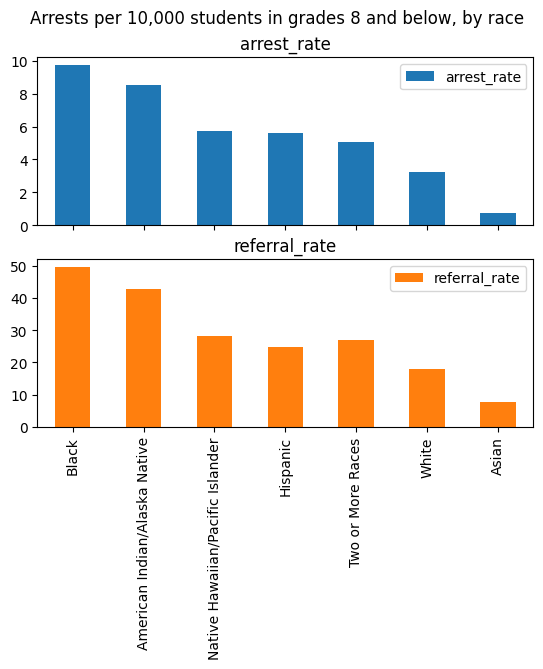

In [26]:
(
    race_national[["referral_rate", "arrest_rate"]]
    .transpose()
    .unstack(0)
    .droplevel(0, axis=1)
    .sort_values("arrest_rate", ascending=False)
    .sort_index(axis=1)
    .plot(
        kind="bar",
        title=f"Arrests per 10,000 students in grades {MAX_GRADE} and below, by race",
        subplots=True,
    )
)


#### Non-white students compared to White students

array([<AxesSubplot: title={'center': 'arrest_rate'}>,
       <AxesSubplot: title={'center': 'referral_rate'}>], dtype=object)

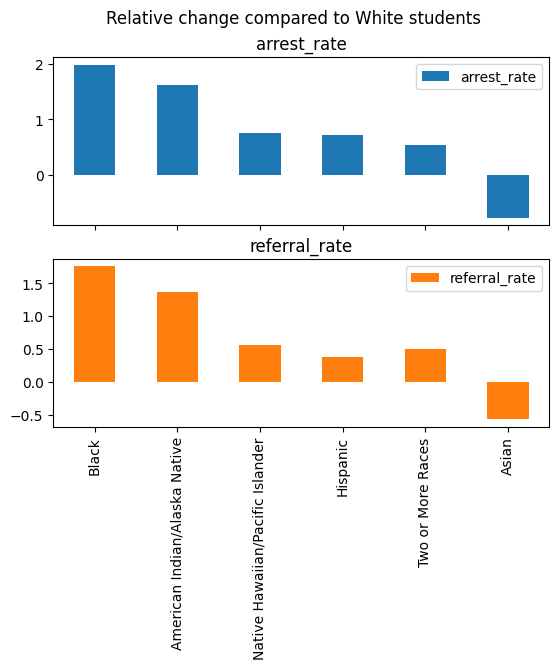

In [27]:
def compare_white(df):
    df = df.copy()
    for col in df:
        if col == "White":
            continue
        df[col] = (df[col] - df["White"]) / df["White"]

    del df["White"]
    return df


(
    race_national.arrest_rate.pipe(compare_white)
    .transpose()
    .rename(columns={"United States": "arrest_rate"})
    .join(
        race_national.referral_rate.pipe(compare_white)
        .transpose()
        .rename(columns={"United States": "referral_rate"})
    )
    .sort_values("arrest_rate", ascending=False)
    .plot(kind="bar", title="Relative change compared to White students", subplots=True)
)


### By state

In [28]:
race_state = (
    race_df.enrollment.reset_index()
    .groupby(["lea_state_name"])
    .sum()
    .pipe(add_col_level, "enrollment")
    .join(
        race_df.arrests.reset_index()
        .groupby(["lea_state_name"])
        .sum()
        .pipe(add_col_level, "arrests")
    )
    .join(
        race_df.referrals.reset_index()
        .groupby(["lea_state_name"])
        .sum()
        .pipe(add_col_level, "referrals")
    )
    .pipe(assign_rates_multiindex)
)

race_state.head()


/tmp/ipykernel_2907/2155311837.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .sum()
/tmp/ipykernel_2907/2155311837.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .sum()
/tmp/ipykernel_2907/2155311837.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .sum()


enrollment                                 \
               American Indian/Alaska Native     Asian     Black   Hispanic   
lea_state_name                                                                
ALABAMA                               4816.0    7674.0  161692.0    40446.0   
ALASKA                               10562.0    4889.0    2413.0     5859.0   
ARIZONA                              34897.0   19848.0   40450.0   351134.0   
ARKANSAS                              2061.0    5212.0   67730.0    43592.0   
CALIFORNIA                           20744.0  471208.0  220210.0  2288907.0   

                                                                             \
               Native Hawaiian/Pacific Islander Two or More Races     White   
lea_state_name                                                                
ALABAMA                                   692.0           11607.0  246047.0   
ALASKA                                   2687.0           10008.0   35605.0   
ARIZONA                                  2730.0           25180.0  280191.0   
ARKANSAS                                 2869.0            9364.0  193469.0   
CALIFORNIA                              24403.0          175421.0  931942.0   

                                     arrests               ...  \
               American Indian/Alaska Native Asian  Black  ...   
lea_state_name                                             ...   
ALABAMA                                  3.0   0.0  159.0  ...   
ALASKA                                   3.0   0.0    0.0  ...   
ARIZONA                                 50.0   4.0   33.0  ...   
ARKANSAS                                 3.0   0.0    2.0  ...   
CALIFORNIA                               4.0  18.0   98.0  ...   

                                    arrest_rate                              \
               Native Hawaiian/Pacific Islander Two or More Races     White   
lea_state_name                                                                
ALABAMA                                0.000000          3.446196  3.332697   
ALASKA                                 0.000000          0.000000  0.000000   
ARIZONA                                3.663004          6.751390  3.533304   
ARKANSAS                               0.000000          2.135839  3.256336   
CALIFORNIA                             0.409786          1.368137  0.933534   

                               referral_rate                                   \
               American Indian/Alaska Native      Asian      Black   Hispanic   
lea_state_name                                                                  
ALABAMA                            14.534884   2.606203  22.079014   7.911784   
ALASKA                             35.978034   4.090816  24.865313  13.654207   
ARIZONA                            98.575809  11.084240  43.016069  32.152967   
ARKANSAS                           43.668122   1.918649   9.892219   9.405395   
CALIFORNIA                         37.119167  11.417463  74.428954  25.370188   

                                                                              
               Native Hawaiian/Pacific Islander Two or More Races      White  
lea_state_name                                                                
ALABAMA                                0.000000          7.753942  14.224925  
ALASKA                                14.886491         13.988809  11.234377  
ARIZONA                               25.641026         27.005560  19.343948  
ARKANSAS                               0.000000         14.950876  17.005308  
CALIFORNIA                            18.850141         29.129922  18.574117  

[5 rows x 35 columns]

In [29]:
race_white_compare_state = (
    compare_white(race_state.arrest_rate)
    .pipe(add_col_level, "arrest_rate")
    .join(compare_white(race_state.referral_rate).pipe(add_col_level, "referral_rate"))
)

race_white_compare_state.head()


arrest_rate                                \
               American Indian/Alaska Native     Asian     Black  Hispanic   
lea_state_name                                                               
ALABAMA                             0.869128 -1.000000  1.950617 -0.554877   
ALASKA                                   inf       NaN       NaN       NaN   
ARIZONA                             3.055094 -0.429623  1.308949  1.595386   
ARKANSAS                            3.470068 -1.000000 -0.909318 -0.577317   
CALIFORNIA                          1.065557 -0.590806  3.767148  0.694143   

                                                                   \
               Native Hawaiian/Pacific Islander Two or More Races   
lea_state_name                                                      
ALABAMA                               -1.000000          0.034056   
ALASKA                                      NaN               NaN   
ARIZONA                                0.036708          0.910787   
ARKANSAS                              -1.000000         -0.344097   
CALIFORNIA                            -0.561039          0.465545   

                               referral_rate                                \
               American Indian/Alaska Native     Asian     Black  Hispanic   
lea_state_name                                                               
ALABAMA                             0.021790 -0.816786  0.552136 -0.443808   
ALASKA                              2.202495 -0.635866  1.213324  0.215395   
ARIZONA                             4.095951 -0.426992  1.223748  0.662172   
ARKANSAS                            1.567911 -0.887174 -0.418286 -0.446914   
CALIFORNIA                          0.998435 -0.385303  3.007133  0.365889   

                                                                   
               Native Hawaiian/Pacific Islander Two or More Races  
lea_state_name                                                     
ALABAMA                               -1.000000         -0.454905  
ALASKA                                 0.325084          0.245179  
ARIZONA                                0.325532          0.396073  
ARKANSAS                              -1.000000         -0.120811  
CALIFORNIA                             0.014861          0.568307

array([<AxesSubplot: title={'center': '(arrest_rate, American Indian/Alaska Native)'}, ylabel='lea_state_name'>,
       <AxesSubplot: title={'center': '(arrest_rate, Asian)'}, ylabel='lea_state_name'>,
       <AxesSubplot: title={'center': '(arrest_rate, Black)'}, ylabel='lea_state_name'>,
       <AxesSubplot: title={'center': '(arrest_rate, Hispanic)'}, ylabel='lea_state_name'>,
       <AxesSubplot: title={'center': '(arrest_rate, Native Hawaiian/Pacific Islander)'}, ylabel='lea_state_name'>,
       <AxesSubplot: title={'center': '(arrest_rate, Two or More Races)'}, ylabel='lea_state_name'>,
       <AxesSubplot: title={'center': '(referral_rate, American Indian/Alaska Native)'}, ylabel='lea_state_name'>,
       <AxesSubplot: title={'center': '(referral_rate, Asian)'}, ylabel='lea_state_name'>,
       <AxesSubplot: title={'center': '(referral_rate, Black)'}, ylabel='lea_state_name'>,
       <AxesSubplot: title={'center': '(referral_rate, Hispanic)'}, ylabel='lea_state_name'>,
       <A

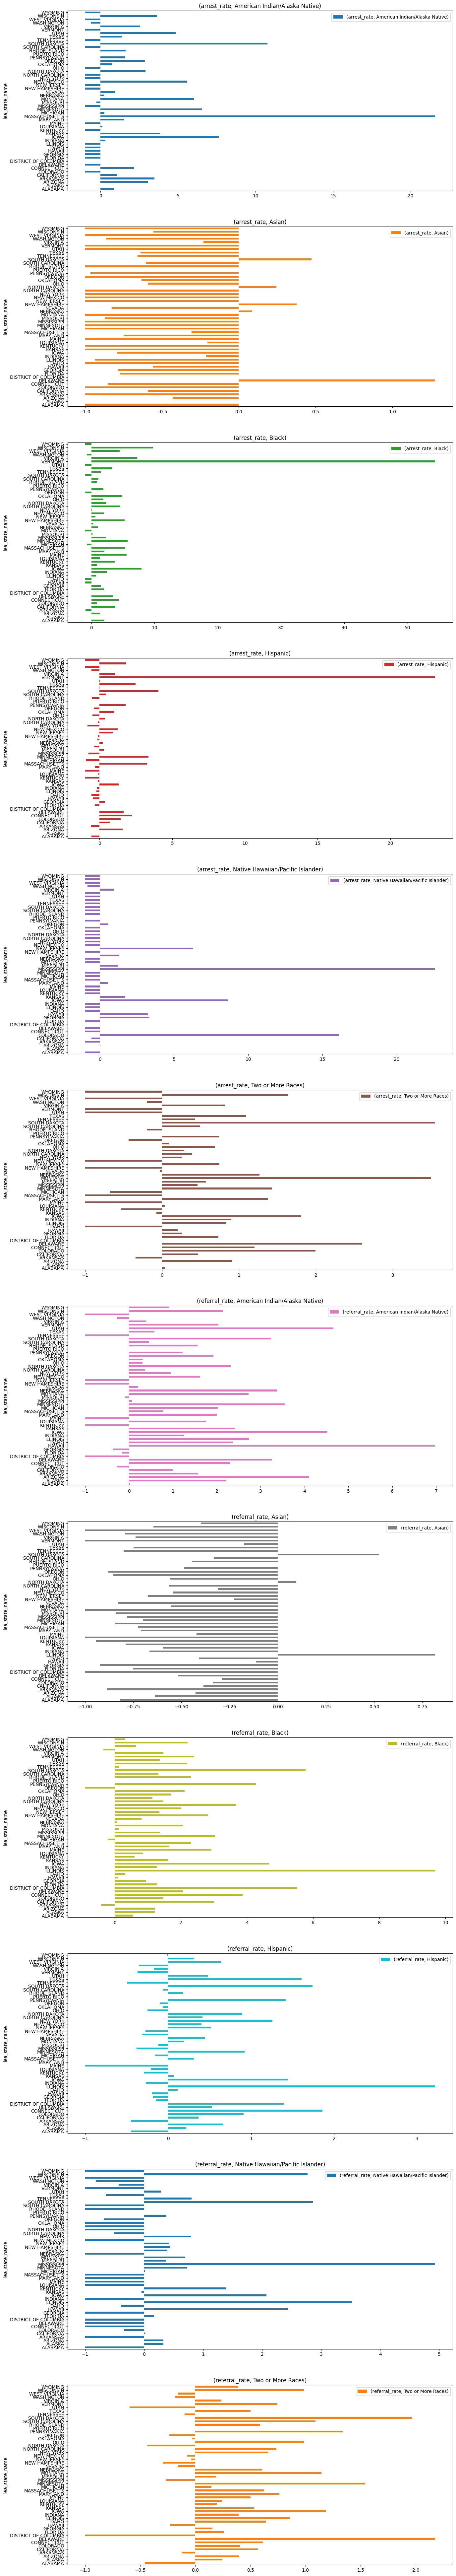

In [30]:
(
    race_white_compare_state.plot(
        kind="barh",
        subplots=True,
        figsize=(15, 100),
        sharex=False,
    )
)


## By disability status

In [31]:
sum_cols = lambda df, kwd, colname: (
    df[[c for c in df.columns if kwd in c]].sum(axis=1).to_frame(colname)
)

dis_df = (
    enr.set_index(INDEX_COLS)
    .pipe(
        lambda df: sum_cols(df, "tot_enr", "total")
        .join(sum_cols(df, "tot_ideaenr", "idea"), **JOIN_ARGS)
        .join(sum_cols(df, "tot_504enr", "section_504"), **JOIN_ARGS)
    )
    .assign(without_disabilities=lambda df: df.total - (df.idea + df["section_504"]))
    .drop("total", axis=1)
    .sort_index(axis=1)
    .pipe(add_col_level, "enrollment")
    .join(
        arr.set_index(INDEX_COLS)
        .pipe(
            lambda df: sum_cols(df, "tot_discwodis_ref", "without_disabilities")
            .join(sum_cols(df, "tot_discwdis_ref_idea", "idea"), **JOIN_ARGS)
            .join(sum_cols(df, "tot_discwdis_ref_504", "section_504"), **JOIN_ARGS)
        )
        .pipe(add_col_level, "referrals"),
        **JOIN_ARGS
    )
    .join(
        arr.set_index(INDEX_COLS)
        .pipe(
            lambda df: sum_cols(df, "tot_discwodis_arr", "without_disabilities")
            .join(sum_cols(df, "tot_discwdis_arr_idea", "idea"), **JOIN_ARGS)
            .join(sum_cols(df, "tot_discwdis_arr_504", "section_504"), **JOIN_ARGS)
        )
        .pipe(add_col_level, "arrests"),
        **JOIN_ARGS
    )
    .join(cha.pipe(add_col_level, "characteristics"), **JOIN_ARGS)
    .pipe(select_schools_multiindex)
)

dis_df.head()


enrollment  \
                                                                                    idea   
combokey     sch_name                      lea_name         lea_state_name jj              
010000500870 Albertville Middle School     Albertville City ALABAMA        No       49.0   
010000500879 Evans Elementary School       Albertville City ALABAMA        No       94.0   
010000500889 Albertville Elementary School Albertville City ALABAMA        No       78.0   
010000502150 Albertville Primary School    Albertville City ALABAMA        No      183.0   
010000600193 Kate Duncan Smith DAR Middle  Marshall County  ALABAMA        No       57.0   

                                                                                           \
                                                                              section_504   
combokey     sch_name                      lea_name         lea_state_name jj               
010000500870 Albertville Middle School     Albertville City ALABAMA        No         4.0   
010000500879 Evans Elementary School       Albertville City ALABAMA        No        10.0   
010000500889 Albertville Elementary School Albertville City ALABAMA        No         0.0   
010000502150 Albertville Primary School    Albertville City ALABAMA        No         0.0   
010000600193 Kate Duncan Smith DAR Middle  Marshall County  ALABAMA        No         7.0   

                                                                                                    \
                                                                              without_disabilities   
combokey     sch_name                      lea_name         lea_state_name jj                        
010000500870 Albertville Middle School     Albertville City ALABAMA        No                754.0   
010000500879 Evans Elementary School       Albertville City ALABAMA        No                750.0   
010000500889 Albertville Elementary School Albertville City ALABAMA        No                828.0   
010000502150 Albertville Primary School    Albertville City ALABAMA        No                831.0   
010000600193 Kate Duncan Smith DAR Middle  Marshall County  ALABAMA        No                354.0   

                                                                                         referrals  \
                                                                              without_disabilities   
combokey     sch_name                      lea_name         lea_state_name jj                        
010000500870 Albertville Middle School     Albertville City ALABAMA        No                  0.0   
010000500879 Evans Elementary School       Albertville City ALABAMA        No                  0.0   
010000500889 Albertville Elementary School Albertville City ALABAMA        No                  0.0   
010000502150 Albertville Primary School    Albertville City ALABAMA        No                  0.0   
010000600193 Kate Duncan Smith DAR Middle  Marshall County  ALABAMA        No                  0.0   

                                                                                    \
                                                                              idea   
combokey     sch_name                      lea_name         lea_state_name jj        
010000500870 Albertville Middle School     Albertville City ALABAMA        No  0.0   
010000500879 Evans Elementary School       Albertville City ALABAMA        No  0.0   
010000500889 Albertville Elementary School Albertville City ALABAMA        No  0.0   
010000502150 Albertville Primary School    Albertville City ALABAMA        No  0.0   
010000600193 Kate Duncan Smith DAR Middle  Marshall County  ALABAMA        No  0.0   

                                                                                           \
                                                                              section_504   
combokey     sch_name                      lea_name         lea_state_name jj          

### National

In [32]:
dis_national = (
    dis_df[["enrollment", "referrals", "arrests"]]
    .sum()
    .to_frame("United States")
    .transpose()
    .pipe(assign_rates_multiindex)
)

dis_national


enrollment                                   \
                    idea section_504 without_disabilities   
United States  4448731.0    807489.0           28308717.0   

                         referrals                                   arrests  \
              without_disabilities     idea section_504 without_disabilities   
United States              59452.0  24913.0         0.0              11791.0   

                                  arrest_rate              \
                 idea section_504        idea section_504   
United States  4847.0         0.0   10.895242         0.0   

                                   referral_rate              \
              without_disabilities          idea section_504   
United States             4.165148     56.000239         0.0   

                                    
              without_disabilities  
United States            21.001305

array([<AxesSubplot: title={'center': 'arrest_rate'}>,
       <AxesSubplot: title={'center': 'referral_rate'}>], dtype=object)

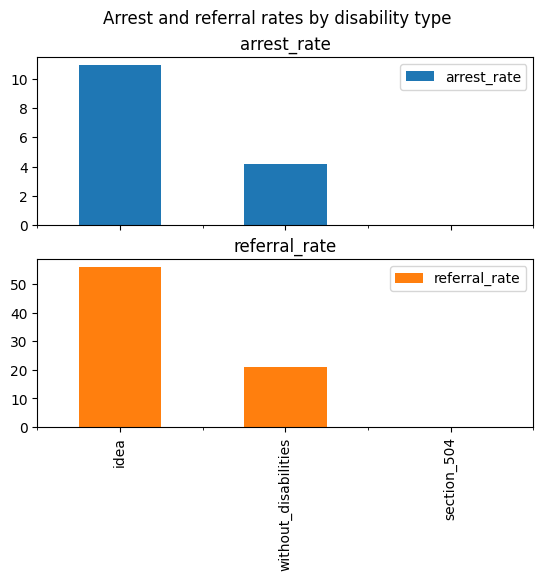

In [33]:
(
    dis_national[["arrest_rate", "referral_rate"]]
    .transpose()
    .unstack(0)
    .droplevel(0, axis=1)
    .sort_values("arrest_rate", ascending=False)
    .plot(
        kind="bar", subplots=True, title="Arrest and referral rates by disability type"
    )
)


### By state

In [34]:
dis_state = (
    dis_df.enrollment.reset_index()
    .groupby("lea_state_name")
    .sum()
    .pipe(add_col_level, "enrollment")
    .join(
        dis_df.referrals.reset_index()
        .groupby("lea_state_name")
        .sum()
        .pipe(add_col_level, "referrals"),
        **JOIN_ARGS
    )
    .join(
        dis_df.arrests.reset_index()
        .groupby("lea_state_name")
        .sum()
        .pipe(add_col_level, "arrests"),
        **JOIN_ARGS
    )
    .pipe(assign_rates_multiindex)
)

dis_state.head()


/tmp/ipykernel_2907/3239631525.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .sum()
/tmp/ipykernel_2907/3239631525.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .sum()
/tmp/ipykernel_2907/3239631525.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .sum()


enrollment                                   \
                     idea section_504 without_disabilities   
lea_state_name                                               
ALABAMA           67213.0      6411.0             395782.0   
ALASKA            10584.0       967.0              60472.0   
ARIZONA           95876.0      8775.0             646498.0   
ARKANSAS          40035.0     11439.0             268784.0   
CALIFORNIA       463770.0     40978.0            3595853.0   

                          referrals                                  arrests  \
               without_disabilities    idea section_504 without_disabilities   
lea_state_name                                                                 
ALABAMA                       557.0   200.0         0.0                147.0   
ALASKA                         83.0    29.0         0.0                  3.0   
ARIZONA                      1836.0   450.0         0.0                443.0   
ARKANSAS                      338.0   123.0         0.0                 48.0   
CALIFORNIA                   8329.0  2020.0         0.0                437.0   

                                  arrest_rate              \
                 idea section_504        idea section_504   
lea_state_name                                              
ALABAMA         107.0         0.0   15.919539         0.0   
ALASKA            0.0         0.0    0.000000         0.0   
ARIZONA          83.0         0.0    8.657015         0.0   
ARKANSAS         28.0         0.0    6.993880         0.0   
CALIFORNIA      157.0         0.0    3.385299         0.0   

                                    referral_rate              \
               without_disabilities          idea section_504   
lea_state_name                                                  
ALABAMA                    3.714166     29.756148         0.0   
ALASKA                     0.496097     27.399849         0.0   
ARIZONA                    6.852303     46.935625         0.0   
ARKANSAS                   1.785821     30.723117         0.0   
CALIFORNIA                 1.215289     43.556073         0.0   

                                     
               without_disabilities  
lea_state_name                       
ALABAMA                   14.073404  
ALASKA                    13.725360  
ARIZONA                   28.399160  
ARKANSAS                  12.575153  
CALIFORNIA                23.162793

In [35]:
idea_vs_nondis = (
    lambda df: (df.idea - df.without_disabilities) / df.without_disabilities
)

dis_state_compare_df = (
    dis_state.arrest_rate.pipe(idea_vs_nondis)
    .to_frame("arrest_rate")
    .join(dis_state.referral_rate.pipe(idea_vs_nondis).to_frame("referral_rate"))
    .sort_values("arrest_rate", ascending=False)
    .pipe(
        add_col_level,
        f"Relative change, idea vs. non-disabled students grades {MAX_GRADE} and below",
    )
)

dis_state_compare_df


Relative change, idea vs. non-disabled students grades 8 and below  \
                                                                            arrest_rate   
lea_state_name                                                                            
VERMONT                                                             inf                   
HAWAII                                                              inf                   
MINNESOTA                                                      7.198948                   
NORTH DAKOTA                                                   4.799269                   
WYOMING                                                        4.742493                   
IDAHO                                                          4.454843                   
MAINE                                                          4.445727                   
IOWA                                                           4.328066                   
DELAWARE                                                       3.959626                   
COLORADO                                                       3.600017                   
WEST VIRGINIA                                                  3.572202                   
NEW YORK                                                       3.303688                   
ALABAMA                                                        3.286168                   
WISCONSIN                                                      3.047598                   
ARKANSAS                                                       2.916340                   
CONNECTICUT                                                    2.831220                   
TENNESSEE                                                      2.651193                   
OHIO                                                           2.516433                   
NORTH CAROLINA                                                 2.433764                   
TEXAS                                                          2.123687                   
KENTUCKY                                                       2.118942                   
OREGON                                                         2.113747                   
NEBRASKA                                                       2.058021                   
SOUTH DAKOTA                                                   2.039624                   
NEW MEXICO                                                     2.024035                   
NEVADA                                                         1.956604                   
FLORIDA                                                        1.933697                   
PENNSYLVANIA                                                   1.932784                   
VIRGINIA                                                       1.907408                   
CALIFORNIA                                                     1.785592                   
MISSOURI                                                       1.775495                   
MICHIGAN                                                       1.690170                   
MARYLAND                                                       1.662767                   
ILLINOIS                                                       1.622960                   
INDIANA                                                        1.373952                   
KANSAS                                                         1.359066                   
SOUTH CAROLINA                                                 1.214215                   
GEORGIA                                                        1.183080                   
DISTRICT OF COLUMBIA                                           1.087898                   
NEW JERSEY                                                     1.054978                   
WASHINGTON                                                     0.967564                   
OKLAHOMA         

array([<AxesSubplot: title={'center': 'Relative change, idea vs. non-disabled students grades 8 and below'}, xlabel='lea_state_name'>,
       <AxesSubplot: title={'center': 'arrest_rate'}, xlabel='lea_state_name'>],
      dtype=object)

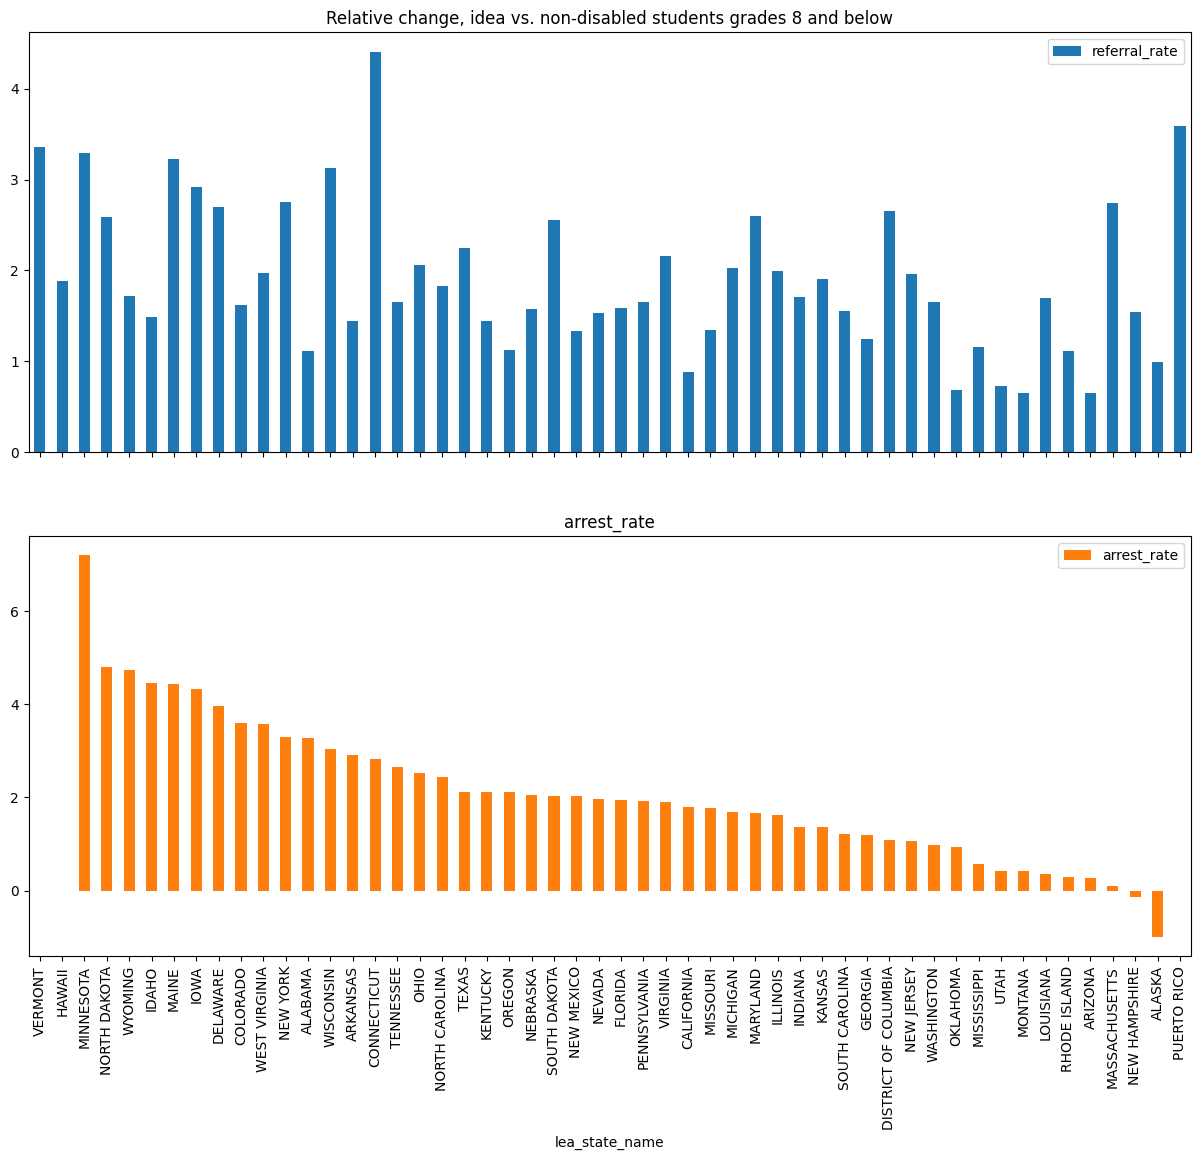

In [36]:
(
    dis_state_compare_df.droplevel(0, axis=1)
    .sort_index(axis=1, ascending=False)
    .plot(
        kind="bar",
        subplots=True,
        figsize=(15, 12),
        title=dis_state_compare_df.columns[0],
    )
)


## Output

In [37]:
state_rates.to_excel(f"output/referrals and arrests, grade {MAX_GRADE} and below.xlsx")
